## Image Processing for VRAR Systems

### This project contains these parts:
1. Distortion
    - Simple Distortion
    - Barrel Distortion
    - Inverse Distortion with/without linear/bilinear interpolation
2. Boundary Blur
3. Disparity Map Generation

### Author: Qian Ruiling

In [ ]:
import os
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.draw import ellipse
from scipy.signal import convolve2d

from pylab import *
from scipy.ndimage import *

#### Get data from files

In [37]:
img_left = cv2.imread(os.path.join(os.getcwd(), 'data/left.jpg'))
img_right = cv2.imread(os.path.join(os.getcwd(), 'data/right.jpg'))
print(img_left.shape)
print(img_right.shape)

(375, 450, 3)
(375, 450, 3)


#### 1. Distortion functions
- Simple Distortion

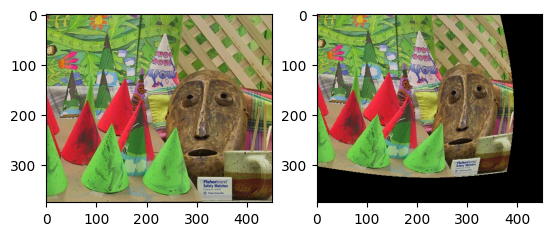

(375, 450, 3)


In [38]:
distorted_img_simple = None
def simple_distortion(k1=0.2, plot=True):
    """
        Apply simple distortion to the image
        :k distortion parameter
        :return: the distorted image
    """
    # Convert image to float32 for accurate calculations
    global distorted_img_simple
    img_left_float = img_left.astype(np.float32)

    # Get image dimensions
    height, width, channels = img_left_float.shape

    # Create distorted image placeholder as a copy of the color image
    distorted_img = np.zeros_like(img_left_float)

    # Get image center coordinates
    center_x = (width) / 2
    center_y = (height) / 2
    d = int(min(width, height) / 2)

    # Iterate through each pixel in the image
    for x in range(width):
        for y in range(height):
            # Calculate the distance from the center
            dx = (x - center_x) / center_x
            dy = (y - center_y) / center_y
            r = math.sqrt(dx**2 + dy**2)

            # Apply radial distortion formula
            radial_x = x * (1 + k1 * r)
            radial_y = y * (1 + k1 * r)

            # Round the coordinates to integers
            radial_x = int(round(radial_x))
            radial_y = int(round(radial_y))

            # Check if the distorted coordinates are within the image bounds
            if 0 <= radial_x < width and 0 <= radial_y < height:
                # Set the pixel color at (x,y) to the color of the distorted pixel at (distorted_x,distorted_y)
                distorted_img[y][x] = img_left[radial_y][radial_x]

    # Convert the distorted image back to uint8
    distorted_img = distorted_img.astype(np.uint8)

    distorted_img_simple = distorted_img

    if plot:
        plt.subplot(121)
        plt.imshow(cv2.cvtColor(img_left, cv2.COLOR_BGR2RGB))
        plt.subplot(122)
        plt.imshow(cv2.cvtColor(distorted_img_simple, cv2.COLOR_BGR2RGB))
        plt.show()
simple_distortion()
print(distorted_img_simple.shape)

- Barrel distortion function

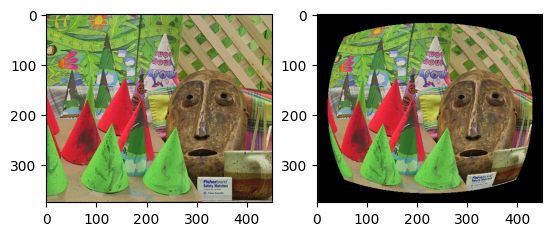

In [39]:
def barrel_distortion(k1=None, k2=None, k3=None, p1=None, p2=None, type=None, plot=True):
    """
        Apply barrel distortion to the image
        :k distortion parameter
        :return: the distorted image
    """

    k1 = -0.05
    k2 = 0.05
    k3 = 0.2
    p1 = 0
    p2 = 0
    global distorted_img_barrel

    # Convert image to float32 for accurate calculations
    img_left_float = img_left.astype(np.float32)

    # Get image dimensions
    height, width, channels = img_left_float.shape

    # Create distorted image placeholder as a copy of the color image
    distorted_img = np.zeros_like(img_left_float)

    # Get image center coordinates
    center_x = (width) / 2
    center_y = (height) / 2
    d = int(min(width, height) / 2)

    # Iterate through each pixel in the image

    for y in range(height):
        for x in range(width):
            # Calculate the distance from the center

            dx = (x - center_x) / center_x
            dy = (y - center_y) / center_y
            r = math.sqrt(dx**2 + dy**2)
            radial_distortion = 1 + k1 * r**2 + k2 * r**4 + k3 * r**6
            tangential_distortion_x = 2 * p1 * dx * dy + p2 * (r**2 + 2 * dx**2)
            tangential_distortion_y = p1 * (r**2 + 2 * dy**2) + 2 * p2 * dx * dy
            distorted_x = int(center_x + center_x *(dx * radial_distortion + tangential_distortion_x))
            distorted_y = int(center_y + center_y *(dy * radial_distortion + tangential_distortion_y))

            # Check if the distorted coordinates are within the image bounds
            if 0 <= distorted_x < width and 0 <= distorted_y < height:
                # Set the pixel color at (x,y) to the color of the distorted pixel at (distorted_x,distorted_y)
                distorted_img[y][x] = img_left[distorted_y][distorted_x]
    # Convert the distorted image back to uint8
    distorted_img = distorted_img.astype(np.uint8)

    distorted_img_barrel = distorted_img

    if plot:
        plt.subplot(121)
        plt.imshow(cv2.cvtColor(img_left, cv2.COLOR_BGR2RGB))
        plt.subplot(122)
        plt.imshow(cv2.cvtColor(distorted_img_barrel, cv2.COLOR_BGR2RGB))
        plt.show()
barrel_distortion()

#### 2. Reverse distortion functions
- Inverse Simple Distortion

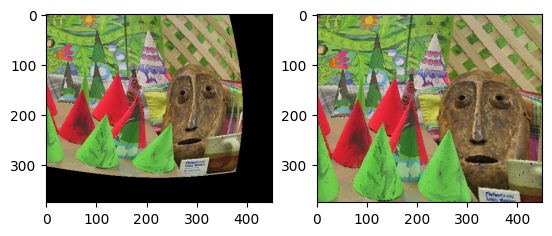

In [40]:
undistorted_img_simple = None
def simple_inverse_distortion(k1=0.2, plot=True):
    """
        Apply simple inverse distortion to the image
        :k distortion parameter
        :return: the undistorted image
    """
    # Convert image to float32 for accurate calculations
    distorted_img_float = distorted_img_simple.astype(np.float32)

    # Get image dimensions
    height, width, channels = distorted_img_float.shape

    # Create undistorted image placeholder as a copy of the distorted image
    undistorted_img = np.zeros_like(distorted_img_float)

    # Get image center coordinates
    center_x = (width) / 2
    center_y = (height) / 2
    d = int(min(width, height) / 2)

    # Iterate through each pixel in the image
    for x in range(width):
        for y in range(height):
            # Calculate the distance from the center
            dx = (x - center_x) / center_x
            dy = (y - center_y) / center_y
            r = math.sqrt(dx**2 + dy**2)

            # Apply inverse radial distortion formula
            inverse_x = x / (1 + k1 * r)
            inverse_y = y / (1 + k1 * r)

            # Round the coordinates to integers
            inverse_x = int(round(inverse_x))
            inverse_y = int(round(inverse_y))

            # Check if the undistorted coordinates are within the image bounds
            if 0 <= inverse_x < width and 0 <= inverse_y < height:
                # Set the pixel color at (x,y) to the color of the undistorted pixel at (undistorted_x,undistorted_y)
                undistorted_img[y][x] = distorted_img_simple[inverse_y][inverse_x]

    # Convert the undistorted image back to uint8
    undistorted_img_simple = undistorted_img.astype(np.uint8)

    if plot:
        plt.subplot(121)
        plt.imshow(cv2.cvtColor(distorted_img_simple, cv2.COLOR_BGR2RGB))
        plt.subplot(122)
        plt.imshow(cv2.cvtColor(undistorted_img_simple, cv2.COLOR_BGR2RGB))
        plt.show()
simple_inverse_distortion()

- Inverse Barrel Distortion Without Interpolated

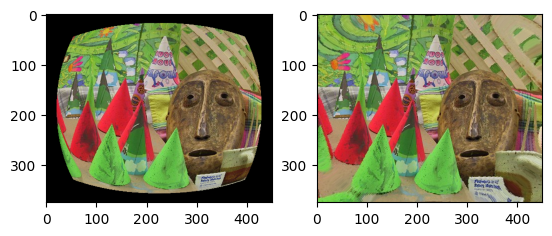

In [41]:
def undistortion_barrel(k1=None, k2=None, k3=None, p1=None, p2=None, type=None, plot=True):
    """
    Undistort the distorted image using barrel distortion parameters
    :return: the undistorted image
    """

    k1 = 0
    k2 = 0
    k3 = 0.1
    p1 = 0
    p2 = 0

    # Convert image to float32 for accurate calculations
    distorted_img_float = distorted_img_barrel.astype(np.float32)

    # Get image dimensions
    height, width, channels = distorted_img_float.shape

    # Create undistorted image placeholder as a copy of the color image
    undistorted_img = np.zeros_like(distorted_img_float)

    # Get image center coordinates
    center_x = (width) / 2
    center_y = (height) / 2
    d = int(min(width, height) / 2)

    # Iterate through each pixel in the image
    for y in range(height):
        for x in range(width):
            # Calculate the distance from the center
            dx = (x - center_x) / center_x
            dy = (y - center_y) / center_y
            r = math.sqrt(dx**2 + dy**2)

            # Calculate the inverse distortion
            radial_distortion = 1 / (1 + k1 * r**2 + k2 * r**4 + k3 * r**6)
            tangential_distortion_x = -2 * p1 * dx * dy - p2 * (r**2 + 2 * dx**2)
            tangential_distortion_y = -p1 * (r**2 + 2 * dy**2) - 2 * p2 * dx * dy
            undistorted_x = int(center_x + center_x * (dx * radial_distortion + tangential_distortion_x))
            undistorted_y = int(center_y + center_y * (dy * radial_distortion + tangential_distortion_y))

            # Check if the undistorted coordinates are within the image bounds
            if 0 <= undistorted_x < width and 0 <= undistorted_y < height:
                # Set the pixel color at (x,y) to the color of the undistorted pixel at (undistorted_x, undistorted_y)
                undistorted_img[y][x] = distorted_img_barrel[undistorted_y][undistorted_x]

    # Convert the undistorted image back to uint8
    undistorted_img = undistorted_img.astype(np.uint8)

    undistorted_img_barrel = undistorted_img

    if plot:
        plt.subplot(121)
        plt.imshow(cv2.cvtColor(distorted_img_barrel, cv2.COLOR_BGR2RGB))
        plt.subplot(122)
        plt.imshow(cv2.cvtColor(undistorted_img_barrel, cv2.COLOR_BGR2RGB))
        plt.show()
undistortion_barrel()

- Inverse Barrel Distortion With Interpolated

In [42]:
def undistortion_interplate(interpolate_type):
    """
    Undistort the distorted image using barrel distortion parameters
    :return: the undistorted image
    """

    k1 = 0
    k2 = 0
    k3 = 0.1
    p1 = 0
    p2 = 0
    plot = True

    # Convert image to float32 for accurate calculations
    distorted_img_float = distorted_img_barrel.astype(np.float32)

    # Get image dimensions
    height, width, channels = distorted_img_float.shape

    # Create undistorted image placeholder as a copy of the color image
    undistorted_img = np.zeros_like(distorted_img_float)

    # Get image center coordinates
    center_x = (width) / 2
    center_y = (height) / 2
    d = int(min(width, height) / 2)

    # Iterate through each pixel in the image
    for y in range(height):
        for x in range(width):
            # Calculate the distance from the center
            dx = (x - center_x) / center_x
            dy = (y - center_y) / center_y
            r = math.sqrt(dx**2 + dy**2)

            # Calculate the inverse distortion
            radial_distortion = 1 / (1 + k1 * r**2 + k2 * r**4 + k3 * r**6)
            tangential_distortion_x = -2 * p1 * dx * dy - p2 * (r**2 + 2 * dx**2)
            tangential_distortion_y = -p1 * (r**2 + 2 * dy**2) - 2 * p2 * dx * dy
            undistorted_x = center_x + center_x * (dx * radial_distortion + tangential_distortion_x)
            undistorted_y = center_y + center_y * (dy * radial_distortion + tangential_distortion_y)

            # Check if the undistorted coordinates are within the image bounds
            if 0 <= undistorted_x < width - 1 and 0 <= undistorted_y < height - 1:
                x1, y1 = int(np.floor(undistorted_x)), int(np.floor(undistorted_y))
                x2, y2 = min(x1 + 1, width - 1), min(y1 + 1, height - 1)
                
                if interpolate_type == 'linear':
                    alpha, beta = undistorted_x - x1, undistorted_y - y1
                    undistorted_img[y][x] = (1 - alpha) * distorted_img_barrel[y1][x1] + alpha * distorted_img_barrel[y1][x2]
                elif interpolate_type == 'bilinear':
                    alpha, beta = undistorted_x - x1, undistorted_y - y1
                    undistorted_img[y][x] = (1 - alpha) * (1 - beta) * distorted_img_barrel[y1][x1] + \
                        alpha * (1 - beta) * distorted_img_barrel[y1][x2] + \
                        (1 - alpha) * beta * distorted_img_barrel[y2][x1] + alpha * beta * distorted_img_barrel[y2][x2]

    # Convert the undistorted image back to uint8
    undistorted_img = undistorted_img.astype(np.uint8)

    interpolated_inverse_barrel_distortion = undistorted_img

    if plot:
        plt.subplot(121)
        plt.imshow(cv2.cvtColor(distorted_img_barrel, cv2.COLOR_BGR2RGB))
        plt.subplot(122)
        plt.imshow(cv2.cvtColor(interpolated_inverse_barrel_distortion, cv2.COLOR_BGR2RGB))
        plt.show()

- Linear

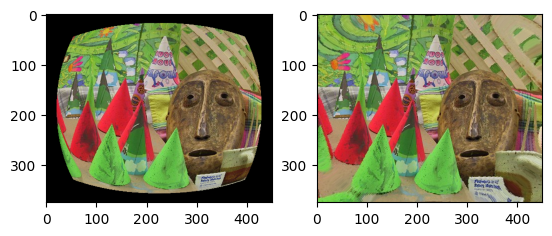

In [43]:
undistortion_barrel('linear')

* Bilinear

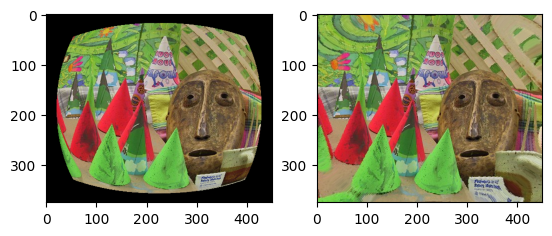

In [44]:
undistortion_barrel('bilinear')

#### 3. Boundary Blur
- I use img_left as an example to show how to do boundary blur. If I used the distorted image, it will not be clear to see the effect of boundary blur.

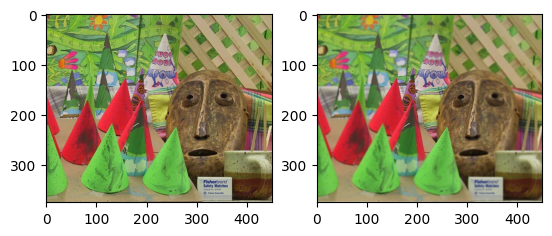

In [45]:
def defocus_blur(plot=True):
    # generate blur kernel
    # kernel_size = (?, ?)
    kernel_size = (5, 5)
    # hints:
    assert kernel_size[0] == kernel_size[1]

    kernel = np.zeros(kernel_size, dtype=np.float32)
    kernel[kernel_size[0]//2, kernel_size[1]//2] = 1
    kernel = gaussian_filter(kernel, 1)
    # todo (1) you need to design the kernel yourselves

    normal_factor = np.sum(kernel)
    kernel = kernel / normal_factor

    # todo (2) adjust kernel (maybe you need to adjust some elements in the kernel to get better results)

    # convolution with kernel
    assert img_left is not None
    blurred_img = np.zeros_like(img_left)
    blurred_img[:, :, 0] = convolve2d(img_left[:, :, 0], kernel, mode='same', fillvalue=255.0).astype(
        'uint8')
    blurred_img[:, :, 1] = convolve2d(img_left[:, :, 1], kernel, mode='same', fillvalue=255.0).astype(
        'uint8')
    blurred_img[:, :, 2] = convolve2d(img_left[:, :, 2], kernel, mode='same', fillvalue=255.0).astype(
        'uint8')

    # restore the original rgb from the center of distorted image
    image_center_ij = np.array(
        [(img_left.shape[0] / 2), (img_left.shape[1] / 2)])
    radius_image = min(
        img_left.shape[0], img_left.shape[1]) / 4
    img_r, img_c = ellipse(
        image_center_ij[0], image_center_ij[1], radius_image, radius_image)
    blurred_img[img_r, img_c, :] = img_left[img_r, img_c, :]

    blurred_img = blurred_img

    if plot:
        plt.subplot(121)
        plt.imshow(cv2.cvtColor(img_left , cv2.COLOR_BGR2RGB))
        plt.subplot(122)
        plt.imshow(cv2.cvtColor(blurred_img , cv2.COLOR_BGR2RGB))
        plt.show()
defocus_blur()

#### 4. Disparity Map Generation

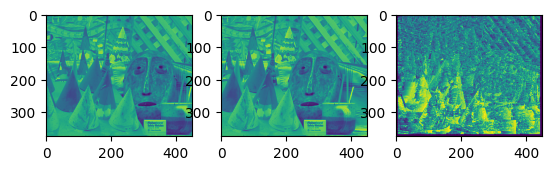

In [46]:
def disparity(start=4, steps=50, wid=13, plot=True):
    """
        estimate depth from disparity calculation
        start: the start index of rolling
        steps: the steps per rolling
        wid: the width of filter
        plot: show the result figures
    """
    disparity_img = np.zeros_like(img_left)
    left_gray = cv2.imread(os.path.join(
       os.getcwd(), 'data/left.jpg'), cv2.IMREAD_GRAYSCALE)
    right_gray = cv2.imread(os.path.join(
        os.getcwd(), 'data/right.jpg'), cv2.IMREAD_GRAYSCALE)

    # todo implement the disparity map calculation algorithm
        # Dimensions of the images
    h, w = left_gray.shape

    # Placeholder for the disparity map
    disparity_img = np.zeros((h, w), np.uint8)
    half_width = wid // 2

    # Iterate through each pixel in the left image
    for y in range(half_width, h - half_width):
        for x in range(half_width, w - half_width):
            best_offset = 0
            prev_ssd = 65534

            # Check each possible disparity value
            for offset in range(start, steps):
                ssd = 0
                # Sum of Squared Differences (SSD)
                ssd_temp = int(left_gray[y, x]) - int(right_gray[y, x - offset])  
                ssd += ssd_temp**2

                # If the current SSD is smaller than the previous SSD, it is a better match
                if ssd < prev_ssd:
                    prev_ssd = ssd
                    best_offset = offset

            # Set the pixel in the disparity map to the best offset value
            disparity_img[y, x] = best_offset
    if plot:
        plt.subplot(131)
        plt.imshow(left_gray)
        plt.subplot(132)
        plt.imshow(right_gray)
        plt.subplot(133)
        plt.imshow(disparity_img)
        plt.show()
disparity()